In [1]:
import twitter

CONSUMER_KEY = "niTpjOMrCL3gijR8V2jJFmVJV"
CONSUMER_SECRET = "dEXpPLbaL90MMMNWnVebaMN1c0s5Mtt2DwOEfcq0eCLE1hBoth"

ACCESS_TOKEN_KEY = "2530119974-TNeh6OBqrCUTIgVWBw8jS0YBdLyuYgfcg3ZNAJx"
ACCESS_TOKEN_SECRET = "eYswE94rxldA8E3LaBvqF9A1Fq8zQZJa72BsFcsExdzfM"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

In [2]:
def download_user_tweets(user_id):
    # Download tweets excluding unnecessary
    statuses = api.GetUserTimeline(user_id, count = 200, include_rts=False, exclude_replies=True, trim_user=True) 
    res_statuses = []
    for status in statuses:
        res_statuses.append(status.AsDict())
        
    return res_statuses

In [3]:
# List of processed users for redownloading
from os import listdir
from os.path import isfile, join

processed_users = [f for f in listdir("tweets") if isfile(join("tweets", f))]

In [4]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

In [5]:
import time

done = 0;
for i in df_users["uid"]:
    done = done + 1
    if str(i) not in processed_users:
        try:
            list_tweet = download_user_tweets(i)
            # Save to folder tweets
            f = open('tweets/' + str(i), 'w')
            json.dump(list_tweet, f)
            print done, " write"
            f.close()
        except Exception as error:
            print error
            if ("code" in error[0][0] and error[0][0]["code"] == 34) or error.message == "Not authorized.":
                continue
            if ("code" in error[0][0] and error[0][0]["code"] == 88):
                # Rate limit
                sleep_time = int(api.GetSleepTime("statuses/user_timeline"))
                if (sleep_time > 0):
                    print "wait:", sleep_time
                    time.sleep(sleep_time)
            continue
    else: 
        print done, " done"
        

1  done
2  done
3  done
4  done
5  done
6  done
7  done
8  done
9  done
10  done
11  done
12  done
13  done
14  done
15  done
16  done
17  done
18  done
19  done
20  done
21  done
22  done
23  done
24  done
25  done
26  done
27  done
28  done
29  done
30  done
31  done
32  done
33  done
34  done
35  done
36  done
37  done
38  done
39  done
40  done
41  done
42  done
43  done
44  done
Not authorized.
46  done
47  done
48  done
49  done
50  done
51  done
52  done
53  done
54  done
55  done
56  done
57  done
58  done
59  done
60  done
61  done
62  done
63  done
64  done
65  done
66  done
67  done
68  done
69  done
70  done
71  done
72  done
73  done
74  done
75  done
76  done
77  done
78  done
79  done
80  done
81  done
82  done
83  done
84  done
85  done
86  done
87  done
88  done
89  done
90  done
91  done
92  done
93  done
94  done
95  done
96  done
97  done
98  done
99  done
100  done
101  done
102  done
103  done
104  done
105  done
106  done
107  done
108  done
109  done
110  done
1

In [6]:
def get_user_tweets(user_id):
    if str(user_id) in processed_users:
        inp = open('tweets/' + str(user_id), 'r')
        tweets = json.loads(inp.readline())
        inp.close()
        return tweets
    else:
        return []

In [7]:
import re
def get_words(text):
    text = text.lower()
    """returns list of words"""
    find = re.findall(r'[^\\=\-?~$%&/\[\]+><{}_^(@)*#\s!,.?":;0-9]+', text)
    return find

In [8]:
print get_words("Here are different words!")

['here', 'are', 'different', 'words']


In [9]:
import nltk

nltk.download("wordnet")
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

wnl = WordNetLemmatizer()
list_stopwords = stopwords.words()

[nltk_data] Downloading package wordnet to /home/zhigan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zhigan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def get_tokens(words):
    """returns list of tokens"""
    list_tokens = [wnl.lemmatize(word) for word in words if wnl.lemmatize(word) not in list_stopwords]
    return list_tokens

In [11]:
def get_tweet_tokens(tweet):
    return get_tokens(get_words(tweet))

In [12]:
print get_tweet_tokens("Here are different words")

['different', u'word']


In [13]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    list_users = []
    list_dict_tokens = []
    # Noise found on tag-cloud
    list_noise = ['http', 'don\'t', 'i\'m', 'it', 'it\'s', 'amp']
    
    done = 0;
    for user in df_users.uid:
        done = done + 1
        print done
        user_tweets = get_user_tweets(user)
        dict_tokens = {}
        for tweet in user_tweets:
            list_tokens = get_tweet_tokens(tweet["text"])
            for token in list_tokens:
                if token in dict_tokens:
                    dict_tokens[token] =  dict_tokens[token] + 1
                else:
                    if len(token) > 1 and token not in list_noise:
                        dict_tokens[token] = 1
        list_users.append(user)
        list_dict_tokens.append(dict_tokens)
        
    return list_users, list_dict_tokens


In [14]:
users, users_tokens = collect_users_tokens(df_users)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [15]:
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

In [16]:
import numpy as np
np.savez("out_4_Roman_Zhiganov.dat", data=vs, users=users, users_tokens=users_tokens)

In [17]:
list_feq = vs.sum(axis = 0)
list_feq = list_feq.tolist()[0]
tokens_feq = zip(v.get_feature_names(), list_feq)

In [18]:
%pylab inline
from PIL import Image
from os import path
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""

    mask = np.array(Image.open(path.join("Resources", "logo.png")))

    wc = WordCloud(background_color="white", max_words=1000, mask=mask,  stopwords=("http"))
    
    wc.generate_from_frequencies(tokens_feq)

    wc.to_file(path.join("Output", "logo_1.png"))
    
    plt.figure(figsize = (12, 12))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    return

/home/zhigan/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy


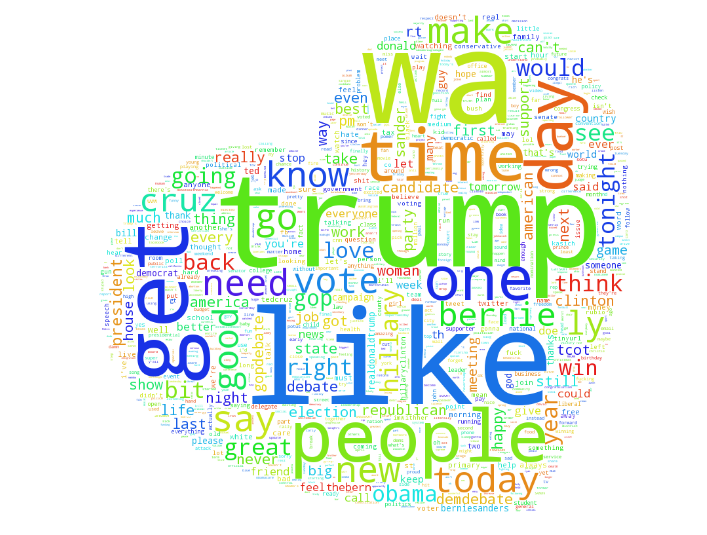

In [28]:
draw_tag_cloud(v, vs)